In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab
from random import randint
import pylab as pl
import matplotlib.patches as patches

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
#https://github.com/smajida/mnist-fun/blob/master/keras_model.py
def add_gaussian_noise(digit, mean, stddev):
    ''' 
    This function adds gaussian noise to the matrix representations
    of the mnist digit
    IN:   
        (1) np array: the MNIST digit representations (n, 784)
        (2) float: the mean of the Gaussian to sample noise from
        (3) float: the standard deviation of the Gaussian to sample
            noise from. Note that the range of pixel values is
            0-255; 
    OUT: 
        (1) np array: noisy training data (n, 784)
    '''
    # #of images (55500 for mnist)
    n_imgs = digit.shape[0]
    # matrix size (784 for mnist)
    n_size = digit.shape[1]
    if stddev == 0:
        noise = np.zeros((n_imgs, n_size))
    else:
        # sample from normal dist
        noise = np.random.normal(mean, stddev/255.,(n_imgs, n_size))
    # add the noise to the data
    x_noisy = digit + noise
    # make sure all data points are in interval [0, 1]
    x_noisy = np.clip(x_noisy, 0., 1.)
    return x_noisy

In [9]:
# create the stddeviations also used for the function above
# I just don't want to run the show_all_noisy_x_example function 
# every time. If you want to reuse it, put it after the stdevs= line
noise_stddevs = np.linspace(0, 192, 97)
digits, labels = mnist.train.images[:], mnist.train.labels[:]
test_digits, test_labels = mnist.test.images[:], mnist.test.labels[:]
# pick the 16, 32 ....
noise_stddevs = np.linspace(0, 192, 97)
stddevs = noise_stddevs[::8]

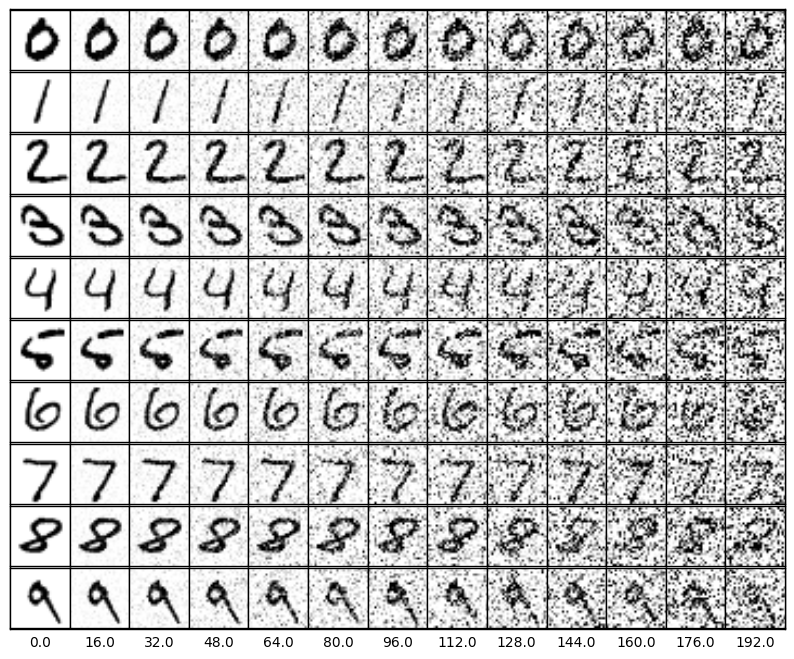

In [10]:
def show_all_noisy_digits(noise_stddevs, x_digit, y_label):
    ''' 
    IN:  
        (1) 1D numpy array: standard deviations of the Gaussian noise to add
            to example images from the X training data. Note that the image
            data has not yet been scaled from 0 to 1, but still has values
            between 0 and 255. Hardcoded to work with the len of this array
            at 97 (the total number of models trained) such that taking 
            every 8th element results in 13 examples (which is the hardcoded
            number of columns for this function)
        (2) (784, ) np array: the MNIST digit representation
        (3) 1D numpy array: y training data: the first instance of each digit
            will be taken from these labels so that an example of each
            digit can be shown
            EXAMPLE: [0,0,1,0,0,0,0,0,0,0] = the digit 2
    OUT: Plots
    
    This function displays an example of each digit from the X training data
    with increasing levels of Gaussian noise on top of it. The function is 
    hardcoded such that 13 examples of increasing noise will be shown. 
    '''
    fig = plt.figure(figsize=(10,8))
    outer_grid = gridspec.GridSpec(10, 13, wspace=0.0, hspace=0.0)
    pylab.xticks([])
    pylab.yticks([])
    
    # more efficient
    first_ind_of_each_num = {}
    for i in range(10):
        counter = 0
        # by inspection: this is enough
        while counter < 100: #len(mnist.test.labels):
            position = np.where(y_label[counter] == 1)[0][0]
            if position not in first_ind_of_each_num:
                first_ind_of_each_num[position] = counter
            counter +=1
    
    for col_ind, noise_stddev in zip(range(13), noise_stddevs[::8]):  
        x_digit_noisy = add_gaussian_noise(x_digit, 0, noise_stddev)
        
        for row_ind in range(10):
            ind_to_plot = col_ind + row_ind * 13
            ax = plt.Subplot(fig, outer_grid[ind_to_plot], aspect = 'equal')
            first_ind_of_this_num = first_ind_of_each_num[row_ind]
            ax.imshow(x_digit_noisy[first_ind_of_this_num].reshape((28,28)), 
                      cmap=plt.cm.Greys)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
            if ax.is_last_row():
                ax.set_xlabel('{}'.format(noise_stddev))              
            # plt customization here.
            plt.subplots_adjust(wspace=0.0,hspace=0.0)    
    plt.savefig("image.png",bbox_inches='tight',dpi=100)
    plt.show()

show_all_noisy_digits(noise_stddevs, test_digits, test_labels)

In [11]:
# visualization 
# http://tneal.org/post/tensorflow-ipython/TensorFlowMNIST/
# A red/black/blue colormap
# Activation of weights
cdict = {'red':   [(0.0,  1.0, 1.0),
                    (0.25,  1.0, 1.0),
                    (0.5,  0.0, 0.0),
                    (1.0,  0.0, 0.0)],
        'green': [(0.0,  0.0, 0.0),
                    (1.0,  0.0, 0.0)],
        'blue':  [(0.0,  0.0, 0.0),
                       (0.5,  0.0, 0.0),
                       (0.75, 1.0, 1.0),
                       (1.0,  1.0, 1.0)]}
redblue = matplotlib.colors.LinearSegmentedColormap('red_black_blue',cdict,256)

In [12]:
# so that we use the same noisy all the time

# THIS CELL WILL HOLD THE X_NOISY NP ARRAY
# so now we can access it by x_noisy[i]
x_noisy = np.zeros([len(stddevs), len(digits), 784])

for i in range(len(stddevs)):
    x_noisy[i] = add_gaussian_noise(digits[:], 0, stddevs[i])

In [13]:
x_noisy_test = np.zeros([len(stddevs), len(test_digits), 784])
for i in range(len(stddevs)):
    x_noisy_test[i] = add_gaussian_noise(test_digits[:], 0, stddevs[i])

In [14]:
# TRAIN ON NORMAL DIGITS OR ON NOISY DIGITS!
def eval_noisy_data(noise_vals, model_name):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) List: list of std deviations (stddevs)
        (2) Int:  model ID: 1 = one_layer, 2=relu, 3= sqr
    OUT: 
        (1) List: list of tuples (Noise, accuracy)
    '''
    
    '''IMPORT THE MODEL'''
    # look at load_model_working
    tf.reset_default_graph()

    sess = tf.InteractiveSession()
    saver = tf.train.import_meta_graph('./models/'+model_name+'.ckpt.meta')
    print saver
    saver.restore(sess, './models/'+model_name+'.ckpt')
    
    all_vars = tf.get_collection('vars')
    
    '''init variables'''
    y_ = tf.placeholder(tf.float32, [None, 10])
    x = sess.graph.get_tensor_by_name("input:0")
    y = sess.graph.get_tensor_by_name("output:0")
    
    # w1 = sess.graph.get_tensor_by_name("w1:0")
    
    if model_name=="conv":
        keep_prob = sess.graph.get_tensor_by_name("keep_prob:0")

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    accuracies = []
    pred_list = []
    corr_list = []
    for i in range(len(noise_vals)):
        # pred_finals hold all the predictions
        if model_name=="conv":
            final = sess.run(accuracy, feed_dict={x: x_noisy_test[i], y_: test_labels, keep_prob:.5})
            corr_pred = sess.run(correct_prediction, feed_dict={x: x_noisy_test[i], y_: test_labels, keep_prob:.5})
            pred_final = sess.run(y, feed_dict={x: x_noisy_test[i], keep_prob:.5})
        # BIRNN model requires data to be in 28x28 format
        elif model_name=="birnn":
            x_data = x_noisy_test[i].copy()
            # defined in models, 1st 28 = timesteps, 2nd is input size (from 28x28)
            x_data = x_data.reshape((-1, 28, 28))
            final = sess.run(accuracy, feed_dict={x: x_data, y_: test_labels})
            corr_pred = sess.run(correct_prediction, feed_dict={x: x_data, y_: test_labels})
            pred_final = sess.run(y, feed_dict={x: x_data})      
        else:
            final = sess.run(accuracy, feed_dict={x: x_noisy_test[i], y_: test_labels})
            corr_pred = sess.run(correct_prediction, feed_dict={x: x_noisy_test[i], y_: test_labels})
            pred_final = sess.run(y, feed_dict={x: x_noisy_test[i]})

        print noise_vals[i], final
        # append to the list
        accuracies.append((noise_vals[i], final))
        pred_list.append((noise_vals[i], pred_final))
        corr_list.append((noise_vals[i], corr_pred))

        # weight activations
        # THESE ARE JUST THE SAME ALL OVER: NOT DYNAMIC
        # print all_vars[0]
        # wts = all_vars[1].eval(feed_dict={x: x_noisy_test[i]})
        # print wts
        # digit 0 activation
        # im = wts.flatten()[0::10].reshape((10,-1))
        # plt.imshow(im, cmap = redblue, clim=(-1.0, 1.0))
        # plt.colorbar()
        # plt.show()

    return accuracies, pred_list, corr_list

## Here we create the accuracy data

In [15]:
accuracies_nsy_one, one_layer_preds, one_layer_corrs = eval_noisy_data(stddevs, "one_layer")

0.0 0.9205
16.0 0.9177
32.0 0.9102
48.0 0.8926
64.0 0.8477
80.0 0.7684
96.0 0.69
112.0 0.6262
128.0 0.5553
144.0 0.4905
160.0 0.44
176.0 0.3876
192.0 0.3451


In [16]:
accuracies_nsy_fb, fb_preds, fb_corrs = eval_noisy_data(stddevs, "two_layer_fb")

0.0 0.9061
16.0 0.904
32.0 0.8943
48.0 0.8674
64.0 0.8123
80.0 0.7383
96.0 0.6423
112.0 0.5695
128.0 0.4923
144.0 0.4214
160.0 0.3866
176.0 0.3479
192.0 0.3196


In [17]:
accuracies_nsy_two, two_preds, two_corrs = eval_noisy_data(stddevs, "two_layer")

0.0 0.9122
16.0 0.911
32.0 0.9013
48.0 0.8701
64.0 0.8116
80.0 0.715
96.0 0.6061
112.0 0.5129
128.0 0.44
144.0 0.3806
160.0 0.3462
176.0 0.3164
192.0 0.2896


In [18]:
accuracies_nsy_lcn, lcn_preds, lcn_corrs = eval_noisy_data(stddevs, "lecun")

0.0 0.9736
16.0 0.9727
32.0 0.9665
48.0 0.9569
64.0 0.928
80.0 0.8728
96.0 0.7765
112.0 0.6897
128.0 0.601
144.0 0.5274
160.0 0.4631
176.0 0.42
192.0 0.3816


In [19]:
accuracies_nsy_relu, relu_preds, relu_corrs = eval_noisy_data(stddevs, "relu")

0.0 0.9671
16.0 0.9637
32.0 0.955
48.0 0.9298
64.0 0.8789
80.0 0.8067
96.0 0.7118
112.0 0.6271
128.0 0.5421
144.0 0.4838
160.0 0.432
176.0 0.3976
192.0 0.359


In [20]:
accuracies_nsy_sqr, one_layer_sqr_preds, one_layer_sqr_corrs = eval_noisy_data(stddevs,"one_layer_sqr")

0.0 0.8913
16.0 0.8918
32.0 0.8902
48.0 0.8873
64.0 0.8798
80.0 0.8648
96.0 0.8381
112.0 0.8048
128.0 0.7583
144.0 0.7116
160.0 0.6821
176.0 0.6455
192.0 0.612


In [21]:
accuracies_nsy_birnn, nsy_birnn_preds, nsy_birnn_corrs = eval_noisy_data(stddevs,"birnn")

0.0 0.9624
16.0 0.9497
32.0 0.8824
48.0 0.7083
64.0 0.4994
80.0 0.3561
96.0 0.2858
112.0 0.2455
128.0 0.2252
144.0 0.2106
160.0 0.1994
176.0 0.1941
192.0 0.1838


In [22]:
# takes a long long time
# NOT TRAINED LONG ENOUGH...
accuracies_nsy_conv, conv_preds, conv_corrs = eval_noisy_data(stddevs,"conv")

0.0 0.9419
16.0 0.9383
32.0 0.933
48.0 0.9238
64.0 0.9073
80.0 0.8674
96.0 0.8169
112.0 0.7571
128.0 0.6874
144.0 0.6172
160.0 0.5565
176.0 0.4994
192.0 0.4662


In [23]:
accuracies_nsy_conv[0] = (0.0, .99160001)

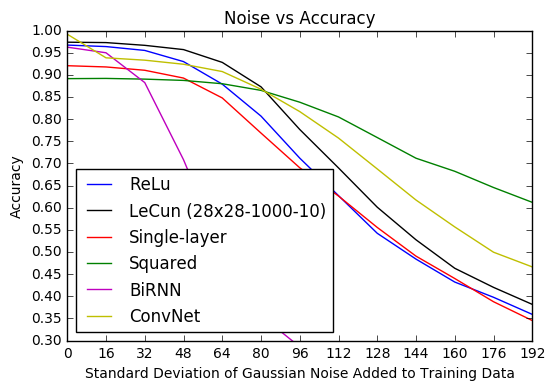

In [24]:
# make nice plot here
plt.title('Noise vs Accuracy')
plt.xlabel('Standard Deviation of Gaussian Noise Added to Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(stddevs))
plt.ylim([0.3,1])
plt.yticks(np.arange(0.3, 1.05, 0.05))
plt.plot(*zip(*accuracies_nsy_relu), c='b', label='ReLu') # or plot for line
plt.plot(*zip(*accuracies_nsy_lcn), c='k', label='LeCun (28x28-1000-10)') # or plot for line
# plt.plot(*zip(*accuracies_nsy_lcn_s), c='c', label='LeCun + Skip') # or plot for line
plt.plot(*zip(*accuracies_nsy_one), c='r', label='Single-layer') # or plot for line
plt.plot(*zip(*accuracies_nsy_sqr), c='g', label='Squared') # or plot for line
plt.plot(*zip(*accuracies_nsy_birnn), c='m', label='BiRNN') # or plot for line
plt.plot(*zip(*accuracies_nsy_conv), c='y', label='ConvNet') # or plot for line
plt.legend(loc=3)
plt.savefig('noise_all.png')
plt.show()

In [25]:
# OREILLY ET AL BLOB BASED OCCLUSION
from random import randint

#N_apply = 2.5 O (I /H + 1) + 0.5
# O = percent of occlusion [0, 1], number of times to apply the filter
# I = Imagesize (28x28)
# H = width of filter = 5% of 28 

# NO GAUSSIAN YET
def add_blob_occlusion(mnist_digits, occ_perc):
    ''' 
    This function adds occlusions to the matrix representations
    of the mnist digits
    IN:   
        (1) np array: the MNIST digit representations (n, 784)
        (2) float: percentage of occlusion after OReilly [0, 1]
    OUT: 
        (1) np array: occluded training data (n, 784)
        
    From O'REILLY et al. 
    The blob-based occlusion algorithm involved the construction of a 
    filter that was set to 1.0 within a circle of radius 5% of the image size 
    (i.e., 5% of 144 pixels or 7 pixels) and then fell off outside   
    
    '''
    # img is 28x28 pixels
    n = 28
    n_apply = 2.5 * occ_perc * (n / (n/20.00) + 1) + 0.5
    # print "applying " + str(int(n_apply)) + " filters"
    # copy because we are going to modify them.
    occluded_digits = np.copy(mnist_digits)
    counter = 0
    for digit in occluded_digits:
        # plt.imshow(mnist_digits[counter].reshape(n,n), cmap = cm.Greys)
        # plt.show()
        # reshape to size n,n
        occluded_digit = digit.reshape(n,n)
        for i in range(int(n_apply)):
            # randint is inclusive
            # make (2, n-r)
            r = 2 # floor(28/20) = 1.4 # Zeiler 144/20 = 7.2
            a = randint(0,n)
            b = randint(0, n)
            # the coordinates
            y,x = np.ogrid[-a:n-a, -b:n-b]
            # create the circular mask
            mask = x*x + y*y <= r*r
            
            # GAUSSIAN HERE??
            # without gaussian you could potentially create new features.
            
            array = np.zeros((n, n))
            # set all values to -1 (neg numbers clipped later)
            array[mask] = -1
            # add the negative values (1-1 = 0 so the max is occluded as well)
            # could also need a gaussian fall off here
            occluded_digit = occluded_digit+array
            # make it in range 0,1 so negative numbers become 0. 
            occluded_digit = np.clip(occluded_digit, 0., 1.)
        
        # set the occluded digit in the nparray
        occluded_digits[counter] = occluded_digit.reshape(784,)
        counter+=1;
   
    return occluded_digits

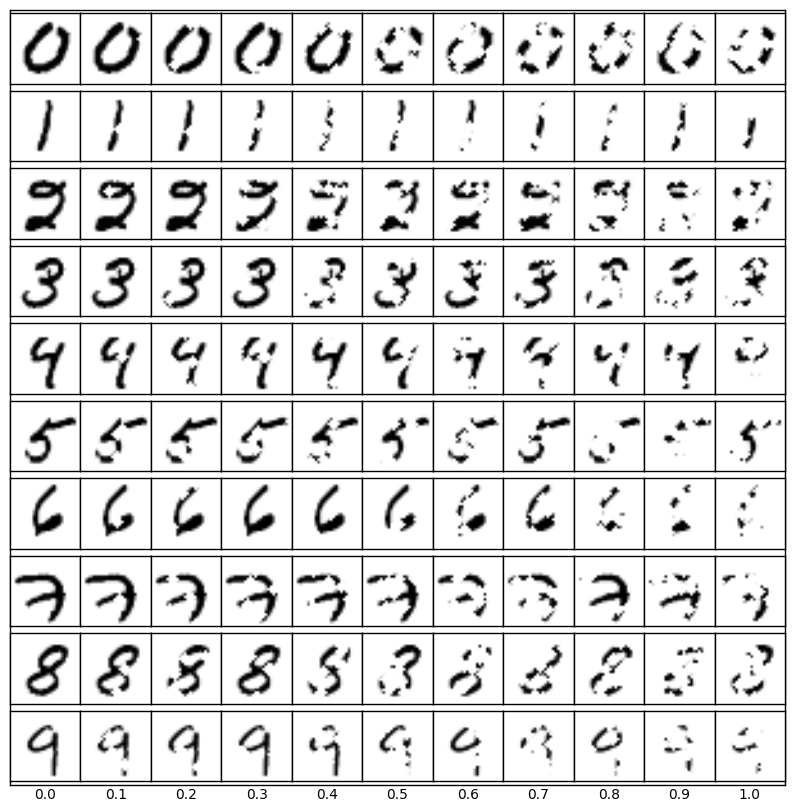

In [26]:
def show_all_occluded_digits(occ_perc, digits, label):
    ''' 
    IN:  
        (1) 1D numpy array: standard deviations of the Gaussian noise to add
            to example images from the X training data. Note that the image
            data has not yet been scaled from 0 to 1, 
        (2) (784, ) np array: the MNIST digit representation
        (3) 1D numpy array: y training data: the first instance of each digit
            will be taken from these labels so that an example of each
            digit can be shown
            EXAMPLE: [0,0,1,0,0,0,0,0,0,0] = the digit 2
    OUT: Plots
    
    This function displays an example of each digit from the X training data
    with increasing levels of occlusions of it. The function is 
    hardcoded such that 10 examples of increasing noise will be shown. 
    '''
    fig = plt.figure(figsize=(10,10))
    outer_grid = gridspec.GridSpec(10, 11, wspace=0.0, hspace=0.0)
    pylab.xticks([])
    pylab.yticks([])
    
    # more efficient
    first_ind_of_each_num = {}
    for i in range(10):
        counter = 0
        # by inspection: this is enough
        while counter < 100: #len(mnist.test.labels):
            position = np.where(labels[counter] == 1)[0][0]
            if position not in first_ind_of_each_num:
                first_ind_of_each_num[position] = counter
            counter +=1
    # loop through every occlusion percentage
    for col_ind, occ_perc in zip(range(11), occ_percs):  
        # digit_occ = add_blob_occlusion(digit, occ_perc)
        
        for row_ind in range(10):
            ind_to_plot = col_ind + row_ind * 11
            ax = plt.Subplot(fig, outer_grid[ind_to_plot])
            first_ind_of_this_num = first_ind_of_each_num[row_ind]
            digit_occ = add_blob_occlusion([digits[first_ind_of_this_num]], occ_perc)
            '''[first_ind_of_this_num]'''
            ax.imshow(digit_occ.reshape((28,28)), 
                      cmap=plt.cm.Greys)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
            if ax.is_last_row():
                ax.set_xlabel('{}'.format(occ_perc))
            plt.subplots_adjust(wspace=0.0,hspace=0.0)
    plt.show()
    
occ_percs = np.linspace(0,1,11)
show_all_occluded_digits(occ_percs, digits, labels)

In [27]:
# so that we use the same occlusions all the time
occ_percs = np.linspace(0,1,11)
x_occ = np.zeros([len(occ_percs), len(digits), 784])
for i in range(len(occ_percs)):
    print occ_percs[i]
    x_occ[i] = add_blob_occlusion(digits[:], occ_percs[i])

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [28]:
x_occ_test = np.zeros([len(occ_percs), len(test_digits), 784])
for i in range(len(occ_percs)):
    x_occ_test[i] = add_blob_occlusion(test_digits[:], occ_percs[i])

In [29]:
def eval_occluded_data(occ_percs, model_name):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) List: list of std deviations (stddevs)
        (2) Int:  model_name, 1:single_layer, 2:relu, 3: one_layer_sqr, 4: conv
    OUT: 
        (1) List: list of tuples (Noise, accuracy)
    '''
    
    '''IMPORT THE MODEL'''
    # look at load_model_working
    tf.reset_default_graph()

    sess = tf.InteractiveSession()
    saver = tf.train.import_meta_graph('./models/'+model_name+'.ckpt.meta')
    # print saver
    saver.restore(sess, './models/'+model_name+'.ckpt')
    
    '''init variables'''
    y_ = tf.placeholder(tf.float32, [None, 10])
    x = sess.graph.get_tensor_by_name("input:0")
    y = sess.graph.get_tensor_by_name("output:0")
    if model_name=="conv":
        keep_prob = sess.graph.get_tensor_by_name("keep_prob:0")

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracies_occ = []
    pred_list = []
    corr_list = []
    for i in range(len(occ_percs)):
        if model_name=="conv":
            final = sess.run(accuracy, feed_dict={x: x_occ_test[i], y_: test_labels, keep_prob:1})
            corr_pred = sess.run(correct_prediction, feed_dict={x: x_occ_test[i], y_: test_labels, keep_prob:1})
            pred_final = sess.run(y, feed_dict={x: x_occ_test[i], keep_prob:1})
        elif model_name=="birnn":
            x_data = x_occ_test[i].copy()
            # defined in models, 1st 28 = timesteps, 2nd is input size (from 28x28)
            x_data = x_data.reshape((-1, 28, 28))
            final = sess.run(accuracy, feed_dict={x: x_data, y_: test_labels})
            corr_pred = sess.run(correct_prediction, feed_dict={x: x_data, y_: test_labels})
            pred_final = sess.run(y, feed_dict={x: x_data})
        else:
            final = sess.run(accuracy, feed_dict={x: x_occ_test[i], y_: test_labels})
            corr_pred = sess.run(correct_prediction, feed_dict={x: x_occ_test[i], y_: test_labels})
            pred_final = sess.run(y, feed_dict={x: x_occ_test[i]})

        print final
        # append to the list
        accuracies_occ.append((occ_percs[i], final))
        pred_list.append((occ_percs[i], pred_final))
        corr_list.append((occ_percs[i], corr_pred))
        
        # weight activations
        '''wts = w1.eval(sess)
        # digit 0 activation
        im = wts.flatten()[0::10].reshape((28,-1))
        plt.imshow(im, cmap = redblue, clim=(-1.0, 1.0))
        plt.colorbar()
        plt.show()
        '''
        
    return accuracies_occ, pred_list, corr_list

### get all the values for the occlusion values

In [30]:
accuracies_occ_one, one_layer_occ_preds, one_layer_occ_corrs  = eval_occluded_data(occ_percs, "one_layer")

0.9205
0.8852
0.8425
0.8024
0.7632
0.731
0.6992
0.6637
0.6326
0.5947
0.5622


In [31]:
accuracies_occ_relu, relu_occ_preds, relu_occ_corrs = eval_occluded_data(occ_percs, "relu")

0.9671
0.9385
0.902
0.8632
0.8297
0.7933
0.7482
0.7168
0.6796
0.644
0.6112


In [32]:
accuracies_occ_sqr, sqr_occ_preds, sqr_occ_corrs = eval_occluded_data(occ_percs, "one_layer_sqr")

0.8913
0.867
0.8409
0.8109
0.7857
0.7649
0.7443
0.7155
0.6903
0.6684
0.6442


In [33]:
accuracies_occ_birnn, birnn_occ_preds, birnn_occ_corrs = eval_occluded_data(occ_percs, "birnn")

0.9624
0.9256
0.8774
0.8338
0.7885
0.7423
0.7036
0.6543
0.6204
0.5816
0.5388


In [34]:
# this will take a some more time
accuracies_occ_conv, conv_occ_preds, conv_occ_corrs = eval_occluded_data(occ_percs, "conv")

0.9568
0.9406
0.9128
0.8898
0.8635
0.8334
0.8018
0.7702
0.7423
0.7026
0.6689


In [35]:
accuracies_occ_conv = [(0.0, 0.99160001), (0.10000000000000001, 0.95870003), (0.20000000000000001, 0.90939999), (0.30000000000000004, 0.8718), (0.40000000000000002, 0.82320002), (0.5, 0.77130002), (0.60000000000000009, 0.74049997), (0.70000000000000007, 0.73149998), (0.80000000000000004, 0.70940002), (0.90000000000000002, 0.68140001), (1.0, 0.66679998)]

//anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


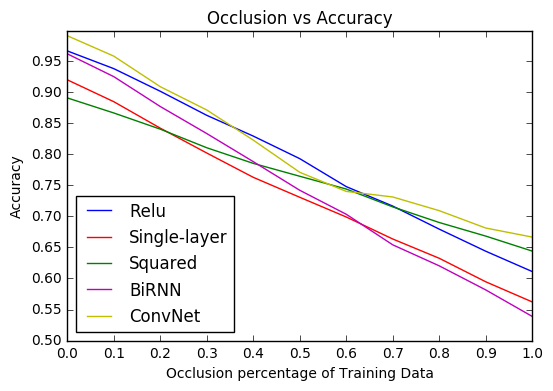

In [36]:
plt.title('Occlusion vs Accuracy')
plt.xlabel('Occlusion percentage of Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(occ_percs))
plt.legend(loc=3)
plt.ylim([0.5,1])
plt.yticks(np.arange(0.5, 1, 0.05))
plt.plot(*zip(*accuracies_occ_relu), c='b', label='Relu') # or plot for line
plt.plot(*zip(*accuracies_occ_one), c='r', label='Single-layer') # or plot for line
plt.plot(*zip(*accuracies_occ_sqr), c='g', label='Squared') # or plot for line
plt.plot(*zip(*accuracies_occ_birnn), c='m', label='BiRNN') # or plot for line
plt.plot(*zip(*accuracies_occ_conv), c='y', label='ConvNet') # or plot for line
plt.legend(loc=3)
plt.savefig('occlusion_all.png')
plt.show()

# Here we start with improvements

## prior
## other

In [37]:
##### AFTER KANDANS EMAIL 13-05
## 1. create priors
'''
So just take all examples of 1 , average them and that 
is the prior or expectation for digit 1. 
The priors will be used as a top down signal. The prior
image will be - some pixels in the prior image will 
be one and the other pixels will be zero. 
'''
##
# create priors of every digit
def create_priors_for_each_digit(digits, labels):
    '''
    IN: 
        (1) (784, ) np array: the MNIST digit representation
        (2) 1D numpy array: y training data
    OUT:
        (1) a (10, 784) numpy array that contains the priors(averages) of all 10 digit classes
        
    This function creates the priors. So just take all 
    examples of 1 , average them and that is the prior 
    or expectation for digit 1. 
    '''
    # 28x28, 0...9 = 10 classes
    digit_size = 784
    digit_classes = 10
    # priors[0] will contain all the 0's
    # priors[1] all the 1's etc.
    # later all the values will be averaged out by the occurence_dict
    priors = np.zeros((digit_classes, digit_size))
    
    # occurences of the digits so we can average out later.
    occurence_dict = {i: 0 for i in range(0,10)}
    
    for i in range(len(labels)):
        # digit_class is the position of the 1 in the label
        # [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.] returns 7.
        digit_class = np.where(labels[i] == 1)[0][0]
        # so (i, digit_class) = position in digits is digit digit_class
        # we have an occurence of this digit.
        occurence_dict[digit_class] += 1
        # update the value of the prior
        priors[digit_class] = np.add(priors[digit_class], digits[i])
        
    print occurence_dict
    
    # elementwise divide all the values in the priors by the #occurences of that digit
    # in this way every value will remain between 0 and 1, just as they are supposed to be   
    for i in range(priors.shape[0]):
        priors[i] = np.divide(priors[i], occurence_dict[i], where=occurence_dict[i]!=0)    
    
    return priors

In [40]:
# CREATE THE BAYES PRIORS
classifier_freq = np.ones(10, dtype=int)
pixel_freq = np.ones((28*28,10), dtype=int)

N = digits.shape[0]
D = digits.shape[1]

for i in range(N):
    c = np.where(labels[i] == 1)[0][0]
    classifier_freq[c] = classifier_freq[c] + 1 # = NC
    for j in range(28 * 28 -1):
        if digits[i][j] != 0:
            pixel_freq[j,c] = pixel_freq[j,c] + 1 # = NiC

#computing posterior means
theta_hat = np.zeros((28 * 28,10), dtype=float)
for c in range(10):
    for i in range(28*28):
        # we just use the pixel prescence, not intensity
        # 255
        theta_hat[i,c] = (theta_hat[i,c] + pixel_freq[i,c]) / classifier_freq[c]

{0: 5444, 1: 6179, 2: 5470, 3: 5638, 4: 5307, 5: 4987, 6: 5417, 7: 5715, 8: 5389, 9: 5454}


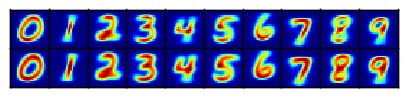

In [41]:
# here is an example of priors with two 8's
# the two 8's are in the first 10 training digits
# plot the two normal 8's 
# plt.imshow(digits[:10][5].reshape((28,28)), cmap = cm.Greys)
# plt.show()
# plt.imshow(digits[:10][9].reshape((28,28)), cmap = cm.Greys)
# plt.show()

fig = plt.figure(figsize=(5,1))
outer_grid = gridspec.GridSpec(2, 10, wspace=0.0, hspace=0.0)
pylab.xticks([])
pylab.yticks([])

priors_test = create_priors_for_each_digit(digits, labels)

'''
for row_ind in range(10):
    ax = plt.Subplot(fig, outer_grid[row_ind], aspect = 'equal')
    ax.matshow(priors_test[row_ind].reshape((28,28)))
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)
    if ax.is_last_row():
        ax.set_xlabel('{}'.format(row_ind))              
    # plt customization here.
    plt.subplots_adjust(wspace=0.0,hspace=0.0) 
'''
    
for col_ind in range(2):
    for i in range(10):   
        ax = plt.Subplot(fig, outer_grid[col_ind,i], aspect = 'equal')
        if col_ind == 0:
            ax.matshow(priors_test[i].reshape((28,28)))
        else:
            ax.matshow(theta_hat[:,i].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        # if ax.is_last_row():
            # ax.set_xlabel([str(i) for i in range(10)])              
        # plt customization here.
        plt.subplots_adjust(wspace=0.0,hspace=0.0)  
   
# plt.colorbar()
plt.savefig("blabla.png",bbox_inches='tight',dpi=100)
plt.show()


# prior of the 8's 
# THIS IS ONLY THE PRIOR FOR THE FIRST 10 DIGITS 
# TO EFFECTIVELY SEE THE DIFFERENCES


# Apply priors

In [42]:
def apply_prior(digits, labels, priors, threshold):
    '''
    COMMENTS
    '''

    priorized_digits = np.copy(digits)
        
    for i in xrange(0, len(digits)):
        digit_class = np.where(labels[i] == 1)[0][0]

        # non-zero elements in the prior
        # select location of pixels in the prior that are not zero
        # first [] has all the pixels, [0] the value
        # print np.argwhere(priors[digit_class] > threshold)
        # idxs = priors[digit_class] > threshold
        # true means: here the prior and digit overlap
        
        zeroArray = np.zeros((784,))
        # http://stackoverflow.com/questions/25103731/numpy-change-elements-matching-conditions
    
        # np.where(condition, valuesWhereTrue, valuesWhereFalse)    
        # so here we set the values to zero that fall out of the prior, zero otherwise
        newArray = np.where(priors[digit_class] > threshold, priorized_digits[i], zeroArray)
        priorized_digits[i] = newArray
        
        return priorized_digits
    
def apply_single_prior(threshold, digit, prior):
    '''
    COMMENTS
    '''
    zeroArray = np.zeros((784,))
    # http://stackoverflow.com/questions/25103731/numpy-change-elements-matching-conditions
    # np.where(condition, valuesWhereTrue, valuesWhereFalse)    
    # so here we set the values to zero that fall out of the prior, zero otherwise
    return np.where(prior > threshold, digit, zeroArray)
    
             
# priors are done with test
var1 = apply_prior([digits[1]], [labels[1]], priors, 0.0)
plt.imshow(var1.reshape((28,28)), cmap = cm.Greys)
plt.show()
# less pixels in the digit now with threshold 0.3
var2 = apply_prior([digits[1]], [labels[1]], priors, 0.3)
plt.imshow(var2.reshape((28,28)), cmap = cm.Greys)
plt.show()
# even less if we increase the threshold
var3 = apply_prior([digits[1]], [labels[1]], priors, 0.5)
plt.imshow(var3.reshape((28,28)), cmap = cm.Greys)
plt.show()

# let's try a noisy example
# 0 least 12 most noisy

# so we pick the same # digit 1 but from the 9th noisiest range
var4 = apply_prior([x_noisy[9][1]], [labels[1]], priors, 0.0)
plt.imshow(var4.reshape((28,28)), cmap = cm.Greys)
plt.show()

var5 = apply_prior([x_noisy[9][1]], [labels[1]], priors, 0.2)
plt.imshow(var5.reshape((28,28)), cmap = cm.Greys)
plt.show()

var6 = apply_prior([x_noisy[9][1]], [labels[1]], priors, 0.4)
plt.imshow(var6.reshape((28,28)), cmap = cm.Greys)
plt.show()

varx = apply_prior([x_noisy[9][1]], [labels[1]], priors, 1)
plt.imshow(varx.reshape((28,28)), cmap = cm.Greys)
plt.show()


# single prior -> we know which prior to apply
# should be the same digit as above.
var7 = apply_single_prior(0.4, [x_noisy[9][1]], priors[3])
plt.imshow(var7.reshape((28,28)), cmap = cm.Greys)
plt.show()

# so if we apply the prior of 4 to a 3 we expect parts of the 3 digit looking like a 4
# it will probably pick the wrong noise / digit areas
var8 = apply_single_prior(0.4, [x_noisy[9][1]], priors[4])

plt.imshow(var8.reshape((28,28)), cmap = cm.Greys)
plt.show()


NameError: name 'priors' is not defined

In [ ]:
print priors.shape
print theta_hat.transpose().shape

In [ ]:
# used to sort the tuples
from operator import itemgetter

def eval_noisy_data_prior(threshold, model_name, noise_vals, apply_one=False):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) List: list of std deviations (stddevs)
        (2) Digits: just like before
        (3) Labels: just like before
    OUT: 
        (1) List: list of tuples (Noise, accuracy)
    '''
    accuracies = []
    
    '''IMPORT THE MODEL'''
    # look at load_model_working
    tf.reset_default_graph()

    sess = tf.InteractiveSession()
    saver = tf.train.import_meta_graph('./models/'+model_name+'.ckpt.meta')
    # print saver
    saver.restore(sess, './models/'+model_name+'.ckpt')
    
    '''init variables'''
    y_ = tf.placeholder(tf.float32, [None, 10])
    x = sess.graph.get_tensor_by_name("input:0")
    y = sess.graph.get_tensor_by_name("output:0")
    if model_name=="conv":
        keep_prob = sess.graph.get_tensor_by_name("keep_prob:0")

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    pred_list = []
    corr_list = []
    for i in range(len(noise_vals)):       
        final = 0
        print noise_vals[i]
        # Apply prior to all the x_noisy to use that as a test
        # this should work as a reinforcer of the already found confidence
        if apply_one == True:
            #
            # CHANGE THESE LINES NOW THEY'RE JUST TO EVALUATE THE DIGITS 
            #
            
            # theta hat for now
            
            x_after_prior = apply_prior(x_noisy_test[i], labels, priors, threshold)
            # predictions_after_prior = sess.run(y, feed_dict={x: x_after_prior}) 
            # correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
            # accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            '''counter = 0
            mistake_list = []
            for k in range(len(predictions_after_prior)):
                if np.argmax(predictions_after_prior[k]) == np.argmax(labels[k]): 
                    # print "found correct-digit:" +  str(y_prior[k]) + str(labels[k])                    
                    counter += 1 # Found a correct digit, increment counter by 1
                    # Simple percentage calculation, which is done for every iteration,
                else:
                    mistake_list.append((np.int8(predictions_after_prior[k]), np.argmax(labels[k])))
                # just a simple calculation
            final = (float(counter)/float(len(predictions_after_prior)))       
            '''
            if model_name=="conv":
                final = sess.run(accuracy, feed_dict={x: x_after_prior, y_: test_labels, keep_prob:1})
            else:
                final = sess.run(accuracy, feed_dict={x: x_after_prior, y_: test_labels})
            
            # this makes consistent 92% as it should
            # final = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            
            print final
        else:
            # these are the highest probabilities of the noisy images
            # these are evaluated on the network trained on normal images
            if model_name=="conv":
                predictions = sess.run(y, feed_dict={x: x_noisy_test[i], keep_prob:1})
            elif model_name=="birnn":
                x_data = x_noisy_test[i].copy()
                # defined in models, 1st 28 = timesteps, 2nd is input size (from 28x28)
                x_data = x_data.reshape((-1, 28, 28))
                predictions = sess.run(y, feed_dict={x: x_data})
            else:
                predictions = sess.run(y, feed_dict={x: x_noisy_test[i]})

            # so now we are going to run through the predictions one by one
            # and then apply priors to the respective first three guesses
            # [7 9 8] highest prob -> apply prior 7 to the digit, then 9 then 8
            # pick the one with the highest resulting probability

            # len(x_noisy[i] is the x_noisy values at noise level i)
            # len(x_noisy[i]) == len(predictions)
            y_prior = np.zeros([len(x_noisy_test[i])])
            for j in range(len(x_noisy_test[i])):
                # so predictions[j] == predictions on x_noisy[i][j]
                # loop through the 3 top predictions (predictions[i]) on x_noisy[i] here          
                acc_after_priors = []
                
                
                for top_three_pred in (-predictions[j]).argsort()[:3].tolist():                
                    # apply prior of the respective prediction
                    # predictions are [8 3 7]
                    # so we apply the priors 8, 3 and 7 on the digit 
                    # and evaluate

                    # apply the single prior
                    # x_noisy[i] means at i'th level of noise, and the j'th element of it (the actual digit) 
                    
                    # theta_hat.transpose() = bayesian
                    # priors = priors
                    new_digit = apply_single_prior(threshold, x_noisy_test[i][j], theta_hat.transpose()[top_three_pred])
                    # print priors[top_three_pred]
                  
                    # plt.imshow(new_digit.reshape((28,28)), cmap = cm.Greys)
                    # plt.show()
                    
                    # http://stackoverflow.com/questions/40430186/tensorflow-valueerror-cannot-feed-value-of-shape-64-64-3-for-tensor-uplace
                    # image has a shape of (64,64,3).
                    # Your input placeholder _x have a shape of (?, 64,64,3).
                    # evaluate score of new digit after applying prior
                    if model_name == "birnn":
                        new_digit = new_digit.reshape([1, 28, 28])                       
                        updt_acc = sess.run(y, feed_dict={x: new_digit, y_: test_labels})
                    else:
                        new_digit = new_digit.reshape([1, 784])                       
                        updt_acc = sess.run(y, feed_dict={x: new_digit})
                    
                    # this is the new prediction for that digit: confidence?
                    # print top_three_pred, updt_acc
                    # print (top_three_pred, updt_acc[0][top_three_pred])
                    # add to list
                    acc_after_priors.append((top_three_pred, updt_acc[0][top_three_pred]))

                # revalue highest prediction for each of the predictions
                # reverse because we need descending order
                sorted_accs = sorted(acc_after_priors,key=itemgetter(1), reverse=True)
                # this would be the highest prediction
                # set this as our classification in x_after_prior
                y_prior[j] = sorted_accs[0][0] 
                
            # evaluate final performance the predicted y's after priors
            # by comparing it to the labels
            corr_numpy = np.empty([len(test_labels)], dtype=bool)
            # print len(y_prior) == len(test_labels)
            acc_count = 0
            # construct wrong/right matrices
            for z in range(len(y_prior)):
                #if z < 10:
                #    print int(y_prior[z]) == np.argmax(test_labels[z])
                #    print int(y_prior[z]) == int(np.argmax(test_labels[z]))
                #    print y_prior[z]
                    
                if int(y_prior[z]) == int(np.argmax(test_labels[z])): 
                    corr_numpy[z] = True
                    acc_count+=1
                else:
                    corr_numpy[z] = False
                    # corr_numpy = np.append(corr_numpy, False)
            # the initial predictions still hold; the label gets changed only after 
            # some manipulations -> IN VISUALIZING JUST SAY APPLY SINGLE PRIOR OF
            # THE PREDICTED LABEL
            print float(acc_count)/float(len(test_labels))
            pred_list.append((noise_vals[i], y_prior))
            corr_list.append((noise_vals[i], corr_numpy))
            accuracies.append((noise_vals[i], float(acc_count)/float(len(test_labels))))
                
    return accuracies, pred_list, corr_list

# NUMERICAL EXAMPLE:

## initial predictions for a digit:
Here the first position indicates the probability of the digit being a 0, the second of being a 1 etc.
```
[  5.31446312e-06   8.28174791e-07   2.49808148e-01   4.79014264e-03
   3.57754296e-04   1.62426397e-06   6.44590591e-06   7.35013783e-01
   4.04045591e-03   5.97557938e-03]
```
Top three predictions are 7, 2 and 9


So we apply the priors and check if the confidence chances.


The 7 in front of the prediction list means we apply the 7 prior
```
7 [  9.89082380e-08   5.06293745e-08   1.42164608e-05   1.20876848e-05
   1.45549957e-05   8.89387124e-08   1.72245862e-09   9.98329461e-01
   3.45648823e-06   1.62606640e-03]
```
So for 7 we get a pretty high confidence (99,8%) after applying the prior.


However, it still might be a 2, so we apply this prior as well.
```
2 [  4.79917726e-05   2.65589351e-05  9.24041152e-01  1.25843119e-02
   2.10321206e-03   3.69884378e-06   1.37797440e-04   3.20478268e-02
   2.07821815e-03   2.69291624e-02]
```
It is also pretty similar to a 2, we get 92 percent that it might be a 2, after we have applied the prior of 2.
It is still a bit less less confident about the 2 than a 7.


Then the 3rd choice: we apply the 9 prior filter and see that although
the probability increases, it is not very high compared to the rest of 
the choices
```
9 [  4.17613364e-06   2.43844697e-05   1.06232800e-02   4.13835078e-04
   2.73833913e-03   2.09397854e-06   2.09301015e-06   8.74718547e-01
   2.09234748e-03   1.09380811e-01]
```
so after applying the priors we get the accuracy list:
```
[(7, 9.98329461e-01), (2, 9.24041152e-01), (9, 1.09380811e-01)]
```
We sort this and find that the 7 has the highest confidence. So we predict this.


## Other prediction
Classifier confidences are 50% of 7, 43% of 2:
```
[  9.48977504e-06   2.29522266e-06   4.35459226e-01   3.43498252e-02
   6.44823594e-04   8.96277834e-06   2.05379874e-05   4.99771178e-01
   5.16357506e-03   2.45700851e-02]
``` 
Let's apply the priors:
```
7 [  2.38011459e-08   1.85446012e-07   1.11220616e-04   2.31126862e-04
   3.62382380e-05   7.75543967e-08   7.31407246e-09   9.96724308e-01
   1.62221149e-05   2.88046827e-03]
```
Wow high confidence of a 7 99,6 percent
```
2 [  5.08271223e-05   1.11595527e-05   7.71899521e-01   1.45516796e-02
   4.58104862e-03   1.29849232e-05   1.16824311e-04   1.28946438e-01
   2.54161446e-03   7.72878677e-02]
```
Applying the 2 filter: we get 77 percent, so this clears the doubt
in this case
```
3 [  2.41471844e-05   7.81904419e-06   5.68024628e-02   4.37496424e-01
   1.04652485e-03   6.83366452e-05   3.74451247e-06   4.91320819e-01
   1.93550077e-04   1.30361076e-02]
```
Might have also been a three though, after prior we still see that it is not confident enough.


Results after prior: 
```
[(7, 0.99672431), (2, 0.77189952), (3, 0.43749642)]
```
We predict 7 with pretty decent confidence, after initially we were in doubt (50% 7 vs. 43% 2) whether we should predict a 7 or a 2.



In [ ]:
# this is the same as the normal noise vs. accuracy ; it is
# accuracies_noisy_prior = eval_noisy_data_prior(0.0, stddevs[:], digits[:], labels[:], True)

# this should also be the same as the normal noise vs accuracy ; it is 
# accuracies_noisy_prior = eval_noisy_data_prior(0.0, stddevs[:], digits[:], labels[:], False)

# this should then improve on that:
# accuracies_noisy_prior = eval_noisy_data_prior(0.1, stddevs[:], digits[:], labels[:], False)

In [ ]:
# priors are created with the training digits： digits
# these results will beidentical to the scores on the model without priors: 
# we don't filter anything

# threshold
# accuracies_noisy_prior_0 = eval_noisy_data_prior(0.0, "one_layer", stddevs[:], False)

######
# THIS IS THE SAME AS accuracies_nsy_one
####

## these have been run; its purpose is to compare none-prior and prior applications
### the prior corrects and predictions are used later to visualize priors + errors

### adding prior to occluded data does not make sense


### FOR BAYES ADD THETHA_HAT IN THE FUNCTION ABOVE

# NOT DONE WITH CURRENT RUN!

In [ ]:
accuracies_bayes_prior_01, bys_01, corrs_01 = eval_noisy_data_prior(0.1, "one_layer", stddevs[:], False)

In [ ]:
accuracies_bayes_prior_02, bys_02, corrs_02 = eval_noisy_data_prior(0.2, "one_layer", stddevs[:], False)

In [ ]:
accuracies_prior_lcn, lcn_preds, lcn_corrs = eval_noisy_data_prior(0.1, "lecun", stddevs[:], False)

In [ ]:
accuracies_bayes_prior_lcn, lcn_bayes_preds, lcn_bayes_corrs = eval_noisy_data_prior(0.1, "lecun", stddevs[:], False)

In [ ]:
accuracies_bayes_prior_lcn_02, lcn_bayes_02_preds, lcn_bayes_02_corrs = eval_noisy_data_prior(0.2, "lecun", stddevs[:], False)

In [ ]:
accuracies_bayes_prior_lcn_04, lcn_bayes_04_preds, lcn_bayes_04_corrs = eval_noisy_data_prior(0.4, "lecun", stddevs[:], False)

In [ ]:
accuracies_fb_sqr, nsy_fb_sqr_preds, nsy_fb_sqr_corrs = eval_noisy_data(stddevs,"one_layer")

In [ ]:
# check cost function in models 
# should be the log one
accuracies_fb, nsy_fb_preds, nsy_fb_corrs = eval_noisy_data(stddevs,"one_layer_fb")

In [ ]:
accuracies_bayes_prior_01_sqr, bys_01_sqr, corrs_01_sqr = eval_noisy_data_prior(0.1, "one_layer_sqr", stddevs[:], False)

In [ ]:
accuracies_bayes_prior_02_sqr, bys_02_sqr, corrs_02_sqr = eval_noisy_data_prior(0.2, "one_layer_sqr", stddevs[:], False)

In [ ]:
accuracies_noisy_prior_01, preds_01, corrs_01 = eval_noisy_data_prior(0.1, "one_layer", stddevs[:], False)

In [ ]:
accuracies_noisy_prior_02, preds_02, corrs_02 = eval_noisy_data_prior(0.2, "one_layer", stddevs[:], False)

In [ ]:
accuracies_noisy_prior_04, preds_04, corrs_04 = eval_noisy_data_prior(0.4, "one_layer", stddevs[:], False)

In [ ]:
accuracies_noisy_prior_01_sqr, preds_sqr_01, corrs_sqr_01 = eval_noisy_data_prior(0.1, "one_layer_sqr", stddevs[:], False)

In [ ]:
accuracies_noisy_prior_02_sqr, preds_sqr_02, corrs_sqr_02 = eval_noisy_data_prior(0.2, "one_layer_sqr", stddevs[:], False)

In [ ]:
accuracies_noisy_prior_04_sqr, preds_sqr_04, corrs_sqr_04 = eval_noisy_data_prior(0.4, "one_layer_sqr", stddevs[:], False)

In [ ]:
accuracies_noisy_prior_01_birnn, _, _ = eval_noisy_data_prior(0.1, "birnn", stddevs[:], False)

In [ ]:
accuracies_noisy_prior_04_birnn, _, _ = eval_noisy_data_prior(0.4, "birnn", stddevs[:], False)

In [ ]:
plt.title('Noise vs Accuracy After Applying Prior - Single_Layer')
plt.xlabel('Standard Deviation of Gaussian Noise Added to Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(stddevs))
plt.plot(*zip(*accuracies_nsy_one), c='b', label='No prior') # or plot for line
# so with 0.0 we get the same result as above.
plt.plot(*zip(*accuracies_noisy_prior_01), c='r', label='Prior 0.1') # or plot for line
# plt.plot(*zip(*accuracies_fb), c='k', label='Feedback') # or plot for line
plt.plot(*zip(*accuracies_bayes_prior_01), c='m', label='Prior 0.1 - Bayes') # or plot for line
plt.plot(*zip(*accuracies_noisy_prior_02), c='y', label='Prior 0.2') # or plot for line
plt.plot(*zip(*accuracies_bayes_prior_02), c='c', label='Prior 0.2 - Bayes') # or plot for line
plt.plot(*zip(*accuracies_noisy_prior_04), c='g', label='Prior 0.4') # or plot for line
plt.legend(loc=3)
plt.savefig('noise_prior_single.png')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

plt.title('Noise vs Accuracy After Applying Prior - LeCun')
plt.xlabel('Standard Deviation of Gaussian Noise Added to Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(stddevs))
plt.plot(*zip(*accuracies_nsy_lcn), c='b', label='No prior') # or plot for line
plt.plot(*zip(*accuracies_prior_lcn), c='r', label='Prior 0.1 - Naive') # or plot for line
plt.plot(*zip(*accuracies_bayes_prior_lcn), c='g', label='Prior 0.1 - Bayes') # or plot for line
plt.plot(*zip(*accuracies_bayes_prior_lcn_02), c='y', label='Prior 0.2 - Bayes') # or plot for line
plt.plot(*zip(*accuracies_bayes_prior_lcn_04), c='c', label='Prior 0.4 - Bayes') # or plot for line
plt.legend(loc=3)
plt.savefig('noise_prior_lecun.png')
plt.show()


## BIRNN
plt.title('Noise vs Accuracy After Applying Prior - BiRNN')
plt.xlabel('Standard Deviation of Gaussian Noise Added to Training Data')
plt.ylabel('Accuracy')
plt.plot(*zip(*accuracies_nsy_birnn), c='b', label='No prior') # or plot for line
# so with 0.0 we get the same result as above.
plt.plot(*zip(*accuracies_noisy_prior_01_birnn), c='r', label='Prior 0.1 - Naive') # or plot for line
plt.plot(*zip(*accuracies_noisy_prior_04_birnn), c='g', label='Prior 0.4 - Naive') # or plot for line
plt.legend(loc=3)
plt.savefig('noise_prior_birnn.png')
plt.show()

plt.title('Noise vs Accuracy After Applying Prior - Single_Layer_Sqr')
plt.xlabel('Standard Deviation of Gaussian Noise Added to Training Data')
plt.ylabel('Accuracy')
## SQRRRRR
plt.plot(*zip(*accuracies_nsy_sqr), c='b', label='No prior') # or plot for line
# so with 0.0 we get the same result as above.
plt.plot(*zip(*accuracies_noisy_prior_01_sqr), c='r', label='Prior 0.1 - Naive') # or plot for line
# plt.plot(*zip(*accuracies_fb_sqr), c='k', label='Feedback') # or plot for line
plt.plot(*zip(*accuracies_bayes_prior_01_sqr), c='m', label='Prior 0.1 - Bayes') # or plot for line
plt.plot(*zip(*accuracies_noisy_prior_02_sqr), c='y', label='Prior 0.2 - Naive') # or plot for line
plt.plot(*zip(*accuracies_bayes_prior_02_sqr), c='c', label='Prior 0.2 - Bayes') # or plot for line
plt.plot(*zip(*accuracies_noisy_prior_04_sqr), c='g', label='Prior 0.4 - Naive') # or plot for line
plt.legend(loc=3)
plt.savefig('noise_prior_single_sqr.png')
plt.show()



In [ ]:
# AFTER MEETING 21-03

# apply prior to top 3 args to pick the right one
# train on normal digits, then evaluate on after_prior
# this creates a possibility of shifting probabilities, because
# now we're assuming the first guess is the right one and 
# the one we apply the prior to (that specific class), such that
# we only reinforce this probability
# More stability allready after this method, but applying to top
# three would be better!
# 
# digit classification: relu after the first 10 input neurons
# - classify normal digits not on noise
# 

# NAIVE BAYES PRIORS

## the priors are created in models.py and has shape 784,10
## NAME THETA HAT -> IN EVAL_PRIOR_DATA

--------------------------

### ------------

In [ ]:
'''
In the meantime, also can you debug the results a bit. 
So for example, visualize images which are wrongly classified. 
both for only classifying the noisy image, and classifying the noisy 
image with priors. And visualize the classifications for which the 
noisy image without prior is correct but the noisy image with prior 
is misclassified. By visualization i mean, show the digits. 
'''
def visualize_wrongs(predictions, corrects, type_digits, plot_range=6):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) NPArray: predictions (pred = sess.run(y, feed ...))
        (2) NPArray: correct predictions (corr = sess.run(correct_prediction, feed ...))
        (3) Str: "occ" for occlusion and else for noisy
        (4) int: range #of plots to show
    OUT: 
        (1) List: list of tuples (Noise, accuracy)
    '''
    fig = plt.figure(figsize=(10,10))
    plt.axis('off')

    # get the occlusion or noise rate
    if type_digits == "occ":
        occ_index = np.where(occ_percs==predictions[0])
        examples = x_occ[occ_index[0][0]].copy()
    else:
        nsy_index = np.where(stddevs==predictions[0])
        examples = x_noisy[nsy_index[0][0]].copy()
    
    # now we only need the contents so not the labels
    predictions = predictions[1]
    corrects = corrects[1]
    cntFalse = 0
    for i, cv in enumerate(corrects):
        if cv==False:
            cntFalse +=1
            ax = fig.add_subplot(5,4,cntFalse)
            ax.axis('off')

            im = np.reshape(examples[i,:], [28,28])
            label = np.argmax(labels[i,:])
            
            pred_label = np.argmax(predictions[i,:])
            ax.imshow(im, cmap='Greys')
            ax.text(0,2, 'true=' + str(label) + ', pred=' + str(pred_label), color='red')
        if cntFalse==plot_range:
            break

In [ ]:
# these are errors without noise
# 0 for nsy = 0.0, 1 = 16, 2 = 32 ...... 12 = 192
visualize_wrongs(one_layer_sqr_preds[12], one_layer_sqr_corrs[12], "nsy", 20)
print one_layer_sqr_corrs[12]


In [ ]:
def visualize_wrongs_priors(predictions, corrects, type_digits, threshold, plot_range=5):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) NPArray: predictions (pred = sess.run(y, feed ...))
        (2) NPArray: correct predictions (corr = sess.run(correct_prediction, feed ...))
        (3) Str: "occ" for occlusion and else for noisy
        (4) int: range #of plots to show
    OUT: 
        (1) List: list of tuples (Noise, accuracy)
    '''
    fig = plt.figure(figsize=(10,10))
    plt.axis('off')

    # get the occlusion or noise rate
    if type_digits == "occ":
        occ_index = np.where(occ_percs==predictions[0])
        examples = x_occ_test[occ_index[0][0]].copy()
    else:
        nsy_index = np.where(stddevs==predictions[0])
        print nsy_index
        examples = x_noisy_test[nsy_index[0][0]].copy()
    
    # now we only need the contents so not the labels
    predictions = predictions[1]
    corrects = corrects[1]
    cntFalse = 0
    for i, cv in enumerate(corrects):
        if cv==False:
            cntFalse +=1
            ax = fig.add_subplot(5,2,cntFalse)
            ax2 = fig.add_subplot(5,2,cntFalse)
            ax.axis('off')
            ax2.axis('off')
            
            
            im = np.reshape(examples[i,:], [28,28])
            # I RAN THIS ON TEST LABELS
            label = np.argmax(test_labels[i])
            pred_label = int(predictions[i])
            
            # PREDICTED PRIOR OR ACTUAL PRIOR?
            im_with_prior = apply_single_prior(threshold, examples[i,:], priors[pred_label])
            im_with_prior = im_with_prior.reshape([28,28])
            ax2.imshow(im_with_prior, cmap='Greys')
            
            
            # ax.imshow(im, cmap='Greys')
            ax.text(0,-2, 'true=' + str(label) + ', pred=' + str(pred_label), color='red')
        if cntFalse==plot_range:
            break

In [ ]:
print preds_01[10][1][63]
print corrs_01[10][1][63]

In [ ]:
visualize_wrongs_priors(preds_04[1], corrs_04[1], "nsy", 0.4, plot_range=10)

'''
print test_labels[10]
varz = x_noisy_test[12][10]
plt.imshow(varz.reshape((28,28)), cmap = cm.Greys)
plt.show()

varx = apply_prior([x_noisy_test[12][10]], [test_labels[10]], priors, 0.4)
plt.imshow(varx.reshape((28,28)), cmap = cm.Greys)
plt.show()
# print corr_sqr
'''

print test_labels[12]


## GENERAL STATISTICS SECTION ABOUT DIGITS

In [ ]:
def digits_wrongs(predictions, corrects, data_list, prior=False):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) NPArray: predictions (pred = sess.run(y, feed ...))
        (2) NPArray: correct predictions (corr = sess.run(correct_prediction, feed ...))
        (3) np.arrange: stddevs or occ_percs 
    OUT: 
        (1) Dict: dictionary containing list of 10 digits with when they were misclassified. 
    '''
    mistake_dict = {}
    
    for i in range(len(data_list)): # get the occlusion or noise rate
        # now we only need the contents so not the labels
        std_or_occ = data_list[i]
        pred_vals = predictions[i][1].copy()
        corr_vals = corrects[i][1].copy()
        mistake_dict[std_or_occ] = {key: [] for key in [i for i in range(10)]}
        for i, cv in enumerate(corr_vals):
            if cv==False:
                # if using conv then change labels into test_label  
                # ALSO FOR PRIOR
                if not prior:
                    label = int(np.argmax(labels[i,:]))
                    pred_label = int(np.argmax(pred_vals[i,:]))
                else:
                    label = int(np.argmax(test_labels[i,:]))
                    pred_label = int(pred_vals[i])
                # print "supposed to be label " + str(label) + ", was " + str(pred_label)
                
                mistake_dict[std_or_occ][label] = mistake_dict[std_or_occ][label] + [pred_label]
                
    return mistake_dict

In [ ]:
# this is for nsy
mistakes_nsy_one_layer = digits_wrongs(one_layer_preds, one_layer_corrs, stddevs)

# so how many 0's were mistaken for 8's at noise level 0.0
print mistakes_nsy_one_layer[0.0][1].count(2)

# so how many 1's were mistaken for 8's at noise level 176.0
print mistakes_nsy_one_layer[176.0][1].count(8)

In [ ]:
mistakes_nsy_one_sqr = digits_wrongs(one_layer_sqr_preds, one_layer_sqr_corrs, stddevs)

In [ ]:
mistakes_occ_one_layer = digits_wrongs(one_layer_occ_preds, one_layer_occ_corrs, occ_percs)

In [ ]:
mistakes_occ_sqr = digits_wrongs(sqr_occ_preds, sqr_occ_corrs, occ_percs)

In [ ]:
mistakes_nsy_one_sqr04 = digits_wrongs(preds_sqr_04, corrs_sqr_04, stddevs, prior=True)

In [ ]:
# http://stackoverflow.com/questions/1518522/python-most-common-element-in-a-list
from collections import Counter
def most_common(lst):
    data = Counter(lst)
    return data.most_common(3)

def all_occurences(lst):
    data = Counter(lst)
    return data.most_common(10)

# all_mistakes = mistakes_nsy_one_layer.copy()
# all_mistakes = mistakes_nsy_one_sqr.copy()
# all_mistakes = mistakes_occ_sqr.copy()
# all_mistakes = mistakes_occ_one_layer.copy()
all_mistakes = mistakes_nsy_one_sqr04.copy()

total_sum = 0
total_mistakes = {}
for noise_val, digit_mistakes in all_mistakes.items():
    print noise_val
    total_mistakes[noise_val] = {key: [] for key in [i for i in range(10)]}
    acc_check = 0
    for i in range(10):
        list_x = all_occurences(digit_mistakes[i])
        # for what were they misclassified?
        print i, list_x       
        # number of misclassified per digits
        # print i,sum([pair[1] for pair in list_x])
        acc_check += sum([pair[1] for pair in list_x])
        
        total_mistakes[noise_val][i] =  sum([pair[1] for pair in list_x])
    print "---"
    # this checks out! with the initial accuracy
    # print 1 - (float(acc_check)/float(55000))

# print total_mistakes

## Apparently 1's are misclassified most often. This might also be because no 1 guesses are made; 8's,5's and 2's are often guessed and therefore more often right

## if we see the lists above however, the main characters that are identified as right are 5's and 3's. It is almost never that other digits are being recognized as 1's. It's just that the ones are most often recognized as something else as the noise increases. Of course; a single bump or blob of noise could more easily deform a one, as opposed to a 2. Initially, the 0's and 1's are the most easily identified digits; this changes very quickly.

### I expect, that with occlusion, the differences are more likely to be between the 3,6,8's.  

In [ ]:
# we now have to sort them to make them useful for plotting
lists = sorted(total_mistakes.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

# this will hold the digit progressions
new_dict = {key: [] for key in [i for i in range(10)]}
# for every stddev
# or occ_percs
for i in range(len(stddevs)):
    # add to that digit's 
    for j in range(10):
        new_dict[j] = new_dict[j] + [y[i][j]]


# plot the data
colors = ['r', 'b', 'y', '#e035b5', '#42f47d', '#1e32b2', 'm', 'k', 'c', '#6e37dd']
for i in range(10):
    plt.plot(x, new_dict[i], '-', label=str(i), color=colors[i])

plt.title('Noisy Digit Errors - Single-layer Sqr + 0.4 Prior')
plt.ylabel('Number of times')
plt.xlabel('Noise Standard Deviation')

plt.xticks(x)

# Put a legend to the right of the current axis
plt.legend(loc=2, bbox_to_anchor=(1,1))
# plt.savefig('wrong_digits_single_sqr.png')
plt.savefig('wrong_digits_nsy_sqr_04.png')
plt.savefig
plt.show()


In [ ]:
# how many times do labels occur
occ_dict = {key: 0 for key in [i for i in range(10)]}
for label in test_labels:
    occ_dict[np.argmax(label)] += 1

In [ ]:
# so at noise level 192, 99.1% of the ones are misclassified
print float(new_dict[1][12])/float(occ_dict[1])

## Skip connection / Feedback

In [ ]:
accuracies_nsy_lcn_s, lcn_s_preds, lcn_s_corrs = eval_noisy_data(stddevs, "lecun_skip")

In [ ]:
accuracies_nsy_lcn_f, lcn_f_preds, lcn_f_corrs = eval_noisy_data(stddevs, "lecun_fb")

In [ ]:
accuracies_nsy_lcn_s_f, lcn_s_f_preds, lcn_s_f_corrs = eval_noisy_data(stddevs, "lecun_skip_fb")

In [ ]:
# accuracies_occ_lcn, lcn_occ_preds, lcn_occ_corrs = eval_occluded_data(occ_percs, "lecun")

In [ ]:
# accuracies_occ_lcn_s, lcn_occ_s_preds, lcn_occ_s_corrs = eval_occluded_data(occ_percs, "lecun_skip")

In [ ]:
# accuracies_occ_lcn_s_f, lcn_s_f_occ_preds, lcn_s_f_occ_corrs = eval_occluded_data(occ_percs, "lecun_skip_fb")

In [ ]:
plt.title('Feedback Loops and Skip Connections')
plt.xlabel('Standard Deviation of Gaussian Noise Added to Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(stddevs))
plt.ylim([0.3,1])
plt.yticks(np.arange(0.3, 1.05, 0.05))


plt.plot(*zip(*accuracies_nsy_lcn), c='k', label='LeCun (28x28-1000-10)') # or plot for line
plt.plot(*zip(*accuracies_nsy_lcn_s), c='b', label='LeCun + Skip') # or plot for line
plt.plot(*zip(*accuracies_nsy_lcn_f), c='g', label='LeCun + Feedback') # or plot for line
plt.plot(*zip(*accuracies_nsy_lcn_s_f), c='r', label='LeCun + Feedback + Skip') # or plot for line
plt.legend(loc=3)
plt.savefig('fb_and_skip.png')
plt.show()